In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from functools import reduce
import datetime as dt

plt.style.use('fivethirtyeight')
#plt.style.use('default')

pd.set_option('display.max_columns',None)
pd.set_option('display.min_rows', None)


from sklearn.decomposition import PCA
from sklearn.metrics  import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [3]:
df_customer = pd.read_csv('df_customer.csv')

In [4]:
df_customer.head()

,cust_id,cust_price_sensitivity,cust_lifestage,total_spend,no_trans
0,CUST0000000013,MM,YF,160.32,12
1,CUST0000000055,LA,YA,433.65,15
2,CUST0000000679,MM,OT,85.63,14
3,CUST0000001052,UM,PE,260.92,31
4,CUST0000001058,UM,OT,71.50,2


In [5]:
df_customer.describe()

,total_spend,no_trans
count,5000.000000,5000.000000
mean,967.003348,78.064000
std,1338.998014,101.654953
min,0.010000,1.000000
25%,60.055000,6.000000
50%,382.935000,40.000000
75%,1396.765000,114.000000
max,14684.060000,926.000000


In [6]:
df_customer.isnull().sum()*100/df_customer.shape[0]

#10.42% of customers do not have a lifestage

cust_id                    0.00
cust_price_sensitivity     0.00
cust_lifestage            10.42
total_spend                0.00
no_trans                   0.00
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d4fd490>,
      dtype=object)

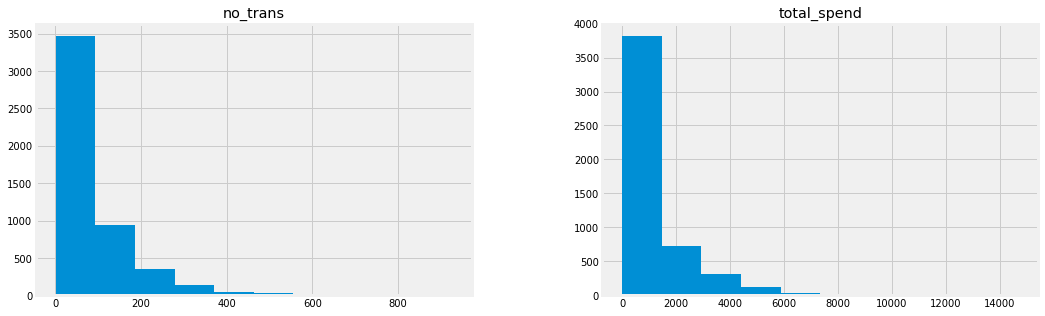

In [7]:
df_customer.hist(figsize=(16,5))

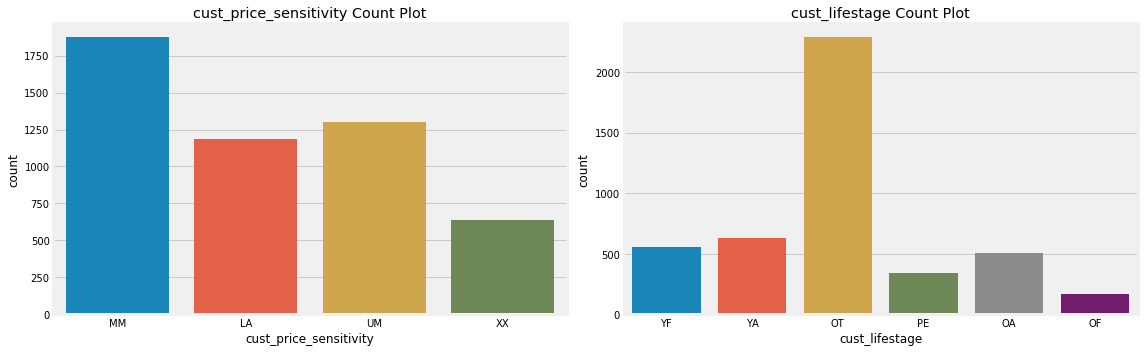

In [8]:
fig, axs = plt.subplots(1,2, figsize = (16,5))
axs = axs.ravel()

for col, ax in zip(df_customer.columns[1:3], axs):
    sns.countplot(x = col,data=df_customer, ax=ax)
    ax.set_title(f'{col} Count Plot')

plt.tight_layout()

In [9]:
df_basket = pd.read_csv('df_basket.csv')

In [10]:
df_basket.head()

,cust_id,basket_id,b_size,b_sens,b_type,b_dom
0,CUST0000000013,994105500169368,L,MM,Top Up,Fresh
1,CUST0000000013,994105900171284,S,MM,Small Shop,Fresh
2,CUST0000000013,994106000168294,L,MM,Full Shop,Fresh
3,CUST0000000013,994106600174081,S,MM,Small Shop,Fresh
4,CUST0000000013,994106700173720,L,MM,Top Up,Fresh


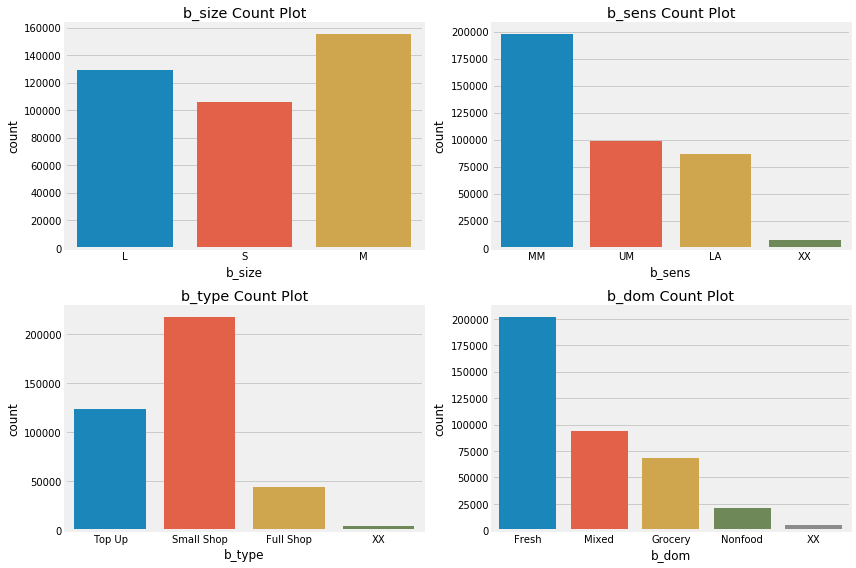

In [11]:
#Let's visualize the basket data
fig, axs = plt.subplots(2,2, figsize = (12,8))
axs = axs.ravel()

for col, ax in zip(df_basket.columns[2:6], axs):
    sns.countplot(x = col,data=df_basket, ax=ax)
    ax.set_title(f'{col} Count Plot')

plt.tight_layout()

In [12]:
#counting the values for each category and storing into data frame
df_size_counts = df_basket.groupby('cust_id').b_size.value_counts().to_frame()
df_sens_counts = df_basket.groupby('cust_id').b_sens.value_counts().to_frame()
df_type_counts = df_basket.groupby('cust_id').b_type.value_counts().to_frame()
df_dom_counts = df_basket.groupby('cust_id').b_dom.value_counts().to_frame()

In [13]:
#setting different index names
df_size_counts.index = df_size_counts.index.set_names(['cust_id', 'size'])
df_sens_counts.index = df_sens_counts.index.set_names(['cust_id', 'sens'])
df_type_counts.index = df_type_counts.index.set_names(['cust_id', 'type'])
df_dom_counts.index = df_dom_counts.index.set_names(['cust_id', 'dom'])

In [14]:
#Remove the multi-index 
df_size_counts.reset_index(inplace=True)
df_sens_counts.reset_index(inplace=True)
df_type_counts.reset_index(inplace=True)
df_dom_counts.reset_index(inplace=True)

In [15]:
#Now we have the counts of each in every category
df_size_counts.head()

,cust_id,size,b_size
0,CUST0000000013,L,7
1,CUST0000000013,S,3
2,CUST0000000013,M,2
3,CUST0000000055,L,9
4,CUST0000000055,S,4


In [16]:
df_size_counts = df_size_counts.pivot(index='cust_id', columns='size', values='b_size').fillna(0).reset_index(inplace=False)
df_sens_counts = df_sens_counts.pivot(index='cust_id', columns='sens', values='b_sens').fillna(0).reset_index(inplace=False)
df_type_counts = df_type_counts.pivot(index='cust_id', columns='type', values='b_type').fillna(0).reset_index(inplace=False)
df_dom_counts = df_dom_counts.pivot(index='cust_id', columns='dom', values='b_dom').fillna(0).reset_index(inplace=False)

In [17]:
#Now we have the count as columns 
df_size_counts.head()

size,cust_id,L,M,S
0,CUST0000000013,7.0,2.0,3.0
1,CUST0000000055,9.0,2.0,4.0
2,CUST0000000679,2.0,11.0,1.0
3,CUST0000001052,1.0,13.0,17.0
4,CUST0000001058,2.0,0.0,0.0


In [18]:
#Create new customer data frame 
basket_dataframes = [df_customer,df_size_counts, df_sens_counts, df_type_counts, df_dom_counts]
df_final = reduce(lambda left,right: pd.merge(left,right,on='cust_id'), basket_dataframes)

In [19]:
df_final.head()

# XX_x is for basket size
# XX_y is for basket price sensitivity
# XX is for basket dominant mission

,cust_id,cust_price_sensitivity,cust_lifestage,total_spend,no_trans,L,M,S,LA,MM,UM,XX_x,Full Shop,Small Shop,Top Up,XX_y,Fresh,Grocery,Mixed,Nonfood,XX
0,CUST0000000013,MM,YF,160.32,12,7.0,2.0,3.0,0.0,10.0,2.0,0.0,1.0,5.0,6.0,0.0,9.0,0.0,3.0,0.0,0.0
1,CUST0000000055,LA,YA,433.65,15,9.0,2.0,4.0,5.0,9.0,1.0,0.0,0.0,6.0,9.0,0.0,2.0,8.0,3.0,2.0,0.0
2,CUST0000000679,MM,OT,85.63,14,2.0,11.0,1.0,5.0,8.0,1.0,0.0,0.0,12.0,2.0,0.0,7.0,3.0,3.0,1.0,0.0
3,CUST0000001052,UM,PE,260.92,31,1.0,13.0,17.0,11.0,16.0,4.0,0.0,0.0,26.0,5.0,0.0,12.0,0.0,5.0,14.0,0.0
4,CUST0000001058,UM,OT,71.50,2,2.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


In [20]:
df_final.isnull().sum()*100/df_final.shape[0]
#same just cust_lifestage is 10.42% empty(521 customers don't have a lifestage attached to them) 

cust_id                    0.00
cust_price_sensitivity     0.00
cust_lifestage            10.42
total_spend                0.00
no_trans                   0.00
L                          0.00
M                          0.00
S                          0.00
LA                         0.00
MM                         0.00
UM                         0.00
XX_x                       0.00
Full Shop                  0.00
Small Shop                 0.00
Top Up                     0.00
XX_y                       0.00
Fresh                      0.00
Grocery                    0.00
Mixed                      0.00
Nonfood                    0.00
XX                         0.00
dtype: float64

In [21]:
#Set X variable
X_all = df_final.drop(columns = ['cust_id','cust_price_sensitivity','cust_lifestage'])
X_all.head()

,total_spend,no_trans,L,M,S,LA,MM,UM,XX_x,Full Shop,Small Shop,Top Up,XX_y,Fresh,Grocery,Mixed,Nonfood,XX
0,160.32,12,7.0,2.0,3.0,0.0,10.0,2.0,0.0,1.0,5.0,6.0,0.0,9.0,0.0,3.0,0.0,0.0
1,433.65,15,9.0,2.0,4.0,5.0,9.0,1.0,0.0,0.0,6.0,9.0,0.0,2.0,8.0,3.0,2.0,0.0
2,85.63,14,2.0,11.0,1.0,5.0,8.0,1.0,0.0,0.0,12.0,2.0,0.0,7.0,3.0,3.0,1.0,0.0
3,260.92,31,1.0,13.0,17.0,11.0,16.0,4.0,0.0,0.0,26.0,5.0,0.0,12.0,0.0,5.0,14.0,0.0
4,71.50,2,2.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


In [22]:
#Scale the data
scaler_all = StandardScaler()
scaler_all.fit(X_all)
X_all_scale = scaler_all.transform(X_all)

In [23]:
#Run KMeans from K from 1 to 9
kmeans_all_loop = [KMeans(random_state=42, n_clusters=k).fit(X_all_scale) for k in range(1,10)]

#Get inertias out of models
kmeans_all_inertias = [model.inertia_ for model in kmeans_all_loop]

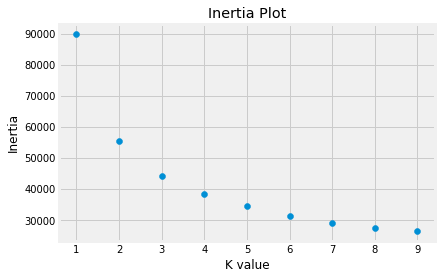

In [24]:
#Plot the inertia plot
plt.scatter(range(1,10), kmeans_all_inertias)
plt.ylabel('Inertia')
plt.xlabel('K value')
plt.title('Inertia Plot');

In [25]:
#PCA
pca = PCA()

X_all_pca = pca.fit_transform(X_all)

In [26]:
pca.explained_variance_ratio_

array([9.90834538e-01, 7.34978743e-03, 5.81221911e-04, 4.66669090e-04,
       2.38306042e-04, 1.96996263e-04, 1.26660863e-04, 8.97963781e-05,
       5.43981506e-05, 2.90029108e-05, 1.64869455e-05, 1.39585548e-05,
       2.17721255e-06, 4.86972029e-34, 1.28437669e-34, 3.02189321e-35,
       1.90147488e-35, 8.29782747e-37])

In [27]:
#The first PC explains about 99% of the total data variance
pca.explained_variance_ratio_[:1].sum()

0.9908345382445588

In [28]:
pca_all = PCA(n_components=1)

pca_all.fit(X_all_scale)

X_all_scale_pca = pca_all.transform(X_all_scale)

In [29]:
#Run KMeans K = 1 to 9
kmean_all_loop_pca = []
kmean_all_inertias_pca = []
for k in range(1,10):
    kmeans_loop = KMeans(n_clusters=k,random_state=12)
    kmeans_loop.fit(X_all_scale_pca)
    
    kmean_all_loop_pca.append(kmeans_loop)
    kmean_all_inertias_pca.append(kmeans_loop.inertia_)

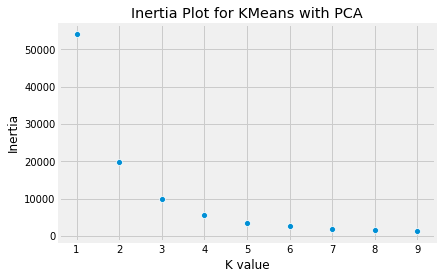

In [30]:
#Plot the inertias
sns.scatterplot(range(1,10), kmean_all_inertias_pca)
plt.ylabel('Inertia')
plt.xlabel('K value')
plt.title('Inertia Plot for KMeans with PCA');

In [31]:
kmean_all_inertias_pca[2]

9952.201912501103

In [32]:
#Create the final model for it
kmean_all_final_pca = kmean_all_loop_pca[2]

In [33]:
#Get the labels and add to dataframe
df_final['all_labels'] = kmean_all_final_pca.labels_
df_final.head()

,cust_id,cust_price_sensitivity,cust_lifestage,total_spend,no_trans,L,M,S,LA,MM,UM,XX_x,Full Shop,Small Shop,Top Up,XX_y,Fresh,Grocery,Mixed,Nonfood,XX,all_labels
0,CUST0000000013,MM,YF,160.32,12,7.0,2.0,3.0,0.0,10.0,2.0,0.0,1.0,5.0,6.0,0.0,9.0,0.0,3.0,0.0,0.0,1
1,CUST0000000055,LA,YA,433.65,15,9.0,2.0,4.0,5.0,9.0,1.0,0.0,0.0,6.0,9.0,0.0,2.0,8.0,3.0,2.0,0.0,1
2,CUST0000000679,MM,OT,85.63,14,2.0,11.0,1.0,5.0,8.0,1.0,0.0,0.0,12.0,2.0,0.0,7.0,3.0,3.0,1.0,0.0,1
3,CUST0000001052,UM,PE,260.92,31,1.0,13.0,17.0,11.0,16.0,4.0,0.0,0.0,26.0,5.0,0.0,12.0,0.0,5.0,14.0,0.0,1
4,CUST0000001058,UM,OT,71.50,2,2.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1


In [34]:
pca_all = PCA(n_components=2)

pca_all.fit(X_all_scale)

X_all_scale_pca = pca_all.transform(X_all_scale)

In [353]:
kmean_all_final_pca.labels_

array([1, 1, 1, ..., 0, 2, 0], dtype=int32)

In [36]:
pca_all.explained_variance_ratio_.sum()

0.7461638671811652

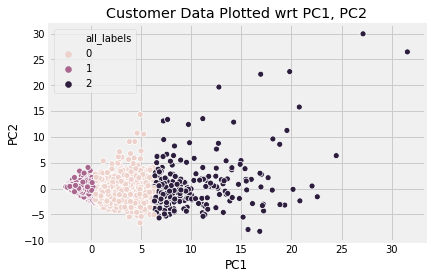

In [37]:
sns.scatterplot(X_all_scale_pca[:,0], X_all_scale_pca[:,1],hue=df_final['all_labels'])

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Customer Data Plotted wrt PC1, PC2');

In [38]:
from mpl_toolkits import mplot3d

pca_all_3 = PCA(n_components=3)
pca_all_3.fit(X_all_scale)
X_all_scale_pca_3 = pca_all_3.transform(X_all_scale)

In [39]:
X_all_scale_pca_3

array([[-2.18262888,  0.16242032, -0.04403161],
       [-1.97537602,  0.1533144 , -0.12405024],
       [-2.13135587,  0.30712048, -0.24859906],
       ...,
       [ 3.36138395, -3.59284987,  2.30294131],
       [ 7.32543984, -4.93217208,  2.84504317],
       [ 1.36999412,  0.42292023, -1.58467176]])

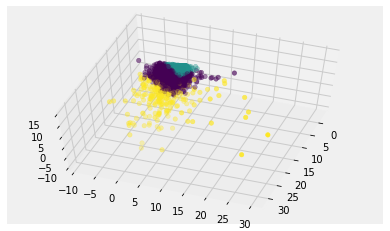

In [40]:
# Turn the dummified df into two columns with PCA
ax1 = plt.axes(projection='3d')
ax1.view_init(60, 20)
# Data for three-dimensional scattered points
ax1.scatter3D(X_all_scale_pca_3[:,0], X_all_scale_pca_3[:,1], X_all_scale_pca_3[:,2], c=df_final['all_labels']);

In [41]:
silhouette_score(X_all_scale_pca, df_final['all_labels'], metric='euclidean')

0.5998424975349186

In [42]:
df_final.head()

,cust_id,cust_price_sensitivity,cust_lifestage,total_spend,no_trans,L,M,S,LA,MM,UM,XX_x,Full Shop,Small Shop,Top Up,XX_y,Fresh,Grocery,Mixed,Nonfood,XX,all_labels
0,CUST0000000013,MM,YF,160.32,12,7.0,2.0,3.0,0.0,10.0,2.0,0.0,1.0,5.0,6.0,0.0,9.0,0.0,3.0,0.0,0.0,1
1,CUST0000000055,LA,YA,433.65,15,9.0,2.0,4.0,5.0,9.0,1.0,0.0,0.0,6.0,9.0,0.0,2.0,8.0,3.0,2.0,0.0,1
2,CUST0000000679,MM,OT,85.63,14,2.0,11.0,1.0,5.0,8.0,1.0,0.0,0.0,12.0,2.0,0.0,7.0,3.0,3.0,1.0,0.0,1
3,CUST0000001052,UM,PE,260.92,31,1.0,13.0,17.0,11.0,16.0,4.0,0.0,0.0,26.0,5.0,0.0,12.0,0.0,5.0,14.0,0.0,1
4,CUST0000001058,UM,OT,71.50,2,2.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1


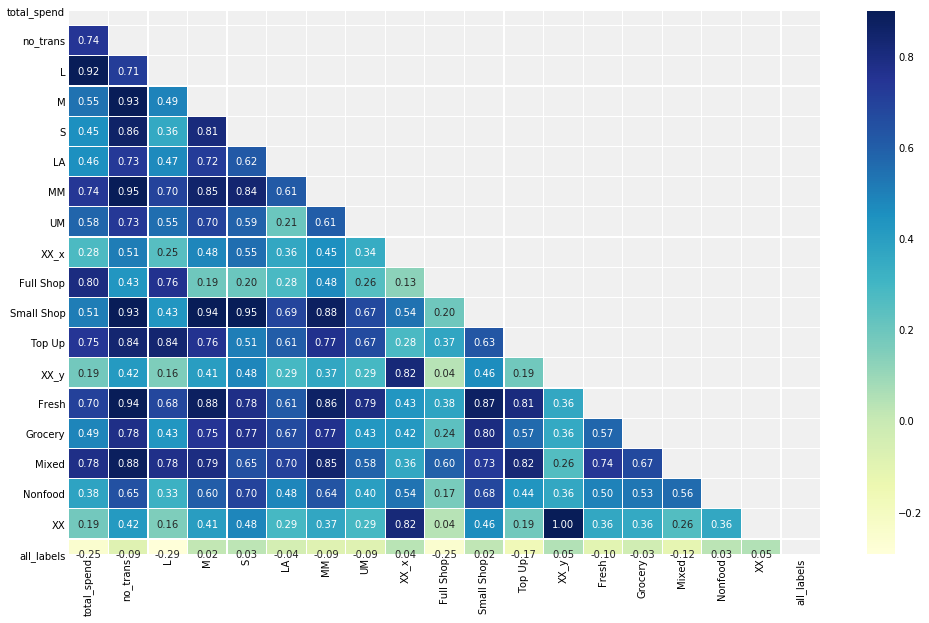

In [43]:
#correlation matrix
corr = df_final.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
# Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr,
            vmax=.9,
            mask=mask,
            annot=True, fmt='.2f',
            linewidths=.2, cmap="YlGnBu");

In [44]:
# #Set variable
# X_all_labels = df_final.drop(columns = ['cust_id','cust_price_sensitivity','cust_lifestage'])

# #pair plot
# sns.pairplot(X_all_labels, hue='all_labels',diag_kind='kde',kind='kde');

In [45]:
#look at data to see what's similar within groups and how they are dissimilar with other groups.
df_final.groupby('all_labels').describe()

total_spend                                                        \
                 count         mean          std     min        25%      50%   
all_labels                                                                     
0               1343.0  2107.751735  1358.202215  179.85  1091.2150  1799.61   
1               3403.0   324.450893   476.723178    0.01    28.6600   128.13   
2                254.0  3544.093583  1859.115476  445.32  2228.8275  3305.57   

                                no_trans                                 \
                  75%       max    count        mean         std    min   
all_labels                                                                
0           2840.1150  14684.06   1343.0  154.153388   48.929055   67.0   
1            426.6250   4880.97   3403.0   24.791948   26.233310    1.0   
2           4509.8925  12732.81    254.0  389.468504  126.371734  176.0   

                                               L                             \
               25%    50%     75%    max   count       mean        std  min   
all_labels                                                                    
0           114.00  146.0  187.00  321.0  1343.0  58.168280  37.130855  0.0   
1             2.00   14.0   42.00  102.0  3403.0   8.374082  12.680893  0.0   
2           297.25  347.0  452.25  926.0   254.0  88.196850  53.240381  0.0   

                                            M                               \
              25%   50%    75%    max   count        mean        std   min   
all_labels                                                                   
0           27.00  55.0   85.0  230.0  1343.0   57.492926  32.707137   0.0   
1            0.00   2.0   11.0   76.0  3403.0    9.558625  11.894637   0.0   
2           46.25  90.0  120.0  332.0   254.0  179.098425  87.996015  53.0   

                                              S                               \
               25%    50%    75%    max   count        mean        std   min   
all_labels                                                                     
0            33.50   53.0   77.5  190.0  1343.0   38.492182  27.834722   0.0   
1             1.00    4.0   15.0   73.0  3403.0    6.859242   9.665778   0.0   
2           116.25  160.0  215.0  536.0   254.0  122.173228  65.411449  13.0   

                                           LA                             \
             25%    50%    75%    max   count       mean        std  min   
all_labels                                                                 
0           17.0   34.0   54.0  165.0  1343.0  34.004468  31.849473  0.0   
1            0.0    3.0   10.0   67.0  3403.0   5.319424   8.634552  0.0   
2           78.0  109.5  148.0  390.0   254.0  91.192913  76.129533  4.0   

                                          MM                               \
             25%   50%    75%    max   count        mean        std   min   
all_labels                                                                  
0           11.0  24.0   48.0  187.0  1343.0   78.038719  33.839764   3.0   
1            0.0   2.0    7.0   69.0  3403.0   12.732883  14.564118   0.0   
2           39.0  67.5  120.0  411.0   254.0  195.346457  78.017418  28.0   

                                            UM                             \
              25%    50%    75%    max   count       mean        std  min   
all_labels                                                                  
0            54.0   73.0   99.0  244.0  1343.0  39.529412  32.954227  0.0   
1             1.0    7.0   20.0   77.0  3403.0   6.327946   9.945442  0.0   
2           144.0  179.0  225.0  494.0   254.0  93.933071  77.027890  0.0   

                                         XX_x                                 \
              25%   50%    75%    max   count      mean        std  min  25%   
all_labels                                                                     
0           14.00  31.0   55.0 

- Cluster 0: 26.9% of customers

- Cluster 1: 68.0% of customers

- Cluster 2: 5.1% of customers

- cluster 2,0,1 in that order have more of everything: 



In [46]:
df_customer.describe()

,total_spend,no_trans
count,5000.000000,5000.000000
mean,967.003348,78.064000
std,1338.998014,101.654953
min,0.010000,1.000000
25%,60.055000,6.000000
50%,382.935000,40.000000
75%,1396.765000,114.000000
max,14684.060000,926.000000


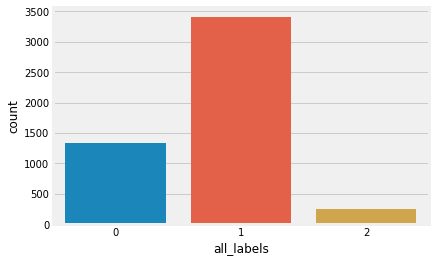

In [47]:
sns.countplot(x = 'all_labels', data = df_final);

#Insight: 
# Cluster 0: 26.9% of customers - Money Makers
# Cluster 1: 68.0% of customers - Majority of Customers
# Cluster 2: 5.1% of customers - Big Spenders



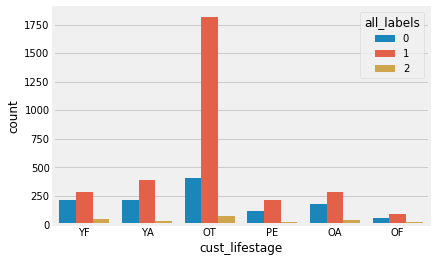

In [48]:
sns.countplot(x = 'cust_lifestage', hue = 'all_labels', data = df_final);

#Insight: Majority of customers are other

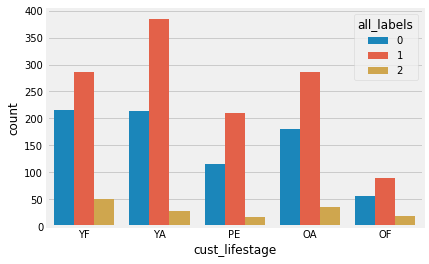

In [49]:
sns.countplot(x = 'cust_lifestage', hue = 'all_labels', data = df_final[df_final['cust_lifestage']!='OT']);

#Cluster 0: 26.9% of customers
#Cluster 1: 68.0% of customers
#Cluster 2: 5.1% of customers

#Insight: Majority of the customers are YA - young adults 

In [50]:
df_final['total_spend'].sum()

#Insight: These 5,000 customers have spent $4,835,016.74

4835016.74

In [389]:
df_final.groupby(['all_labels']).total_spend.sum().reset_index()

,all_labels,total_spend
0,0,2830710.58
1,1,1104106.39
2,2,900199.77


In [52]:
df_final.groupby(['all_labels']).total_spend.mean().reset_index()

,all_labels,total_spend
0,0,2107.751735
1,1,324.450893
2,2,3544.093583


In [423]:
df_final.groupby(['all_labels']).no_trans.sum().reset_index()

,all_labels,no_trans
0,0,207028
1,1,84367
2,2,98925


In [391]:
df_final.groupby(['all_labels']).no_trans.mean().reset_index()

,all_labels,no_trans
0,0,154.153388
1,1,24.791948
2,2,389.468504


In [424]:
df_final['no_trans'].sum()

390320

In [53]:
df_spend_perc = df_final.groupby(['all_labels'])['total_spend'].sum().reset_index()
df_spend_perc = (100. * df_spend_perc['total_spend'] / df_spend_perc['total_spend'].sum()).round(0).reset_index()
df_spend_perc

,index,total_spend
0,0,59.0
1,1,23.0
2,2,19.0


In [54]:
df_final['no_trans'].sum() 

#Insight: These 5000 customers have had 390320 transactions

390320

In [55]:
df_cust_avgspend = df_final.groupby(['cust_lifestage','all_labels']).total_spend.mean().reset_index()

In [56]:
df_cust_sumspend = df_final.groupby(['cust_lifestage','all_labels']).total_spend.sum().reset_index()

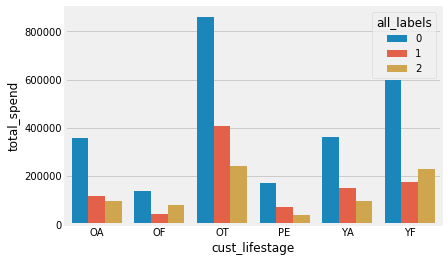

In [57]:
sns.barplot(x = 'cust_lifestage', y='total_spend',hue = 'all_labels', data = df_cust_sumspend);
#Mean total spend
#Insight: YF and OF spend the most money 

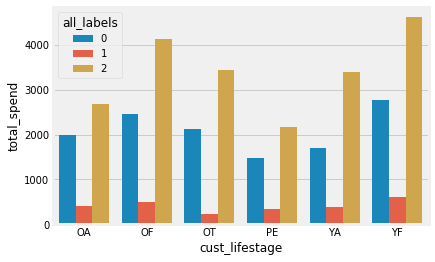

In [58]:
sns.barplot(x = 'cust_lifestage', y='total_spend',hue = 'all_labels', data = df_cust_avgspend);
#Mean total spend
#Insight: YF and OF spend the most money 

In [59]:
df_cust_totaltrans = df_final.groupby(['cust_lifestage','all_labels']).no_trans.mean().reset_index()

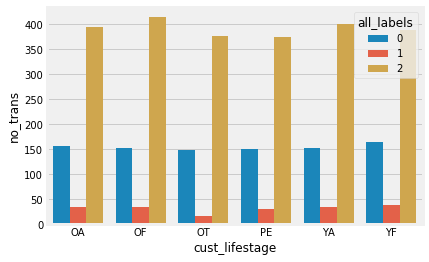

In [60]:
sns.barplot(x = 'cust_lifestage', y='no_trans',hue = 'all_labels', data = df_cust_totaltrans);

#Insight: all similar # of average transactions

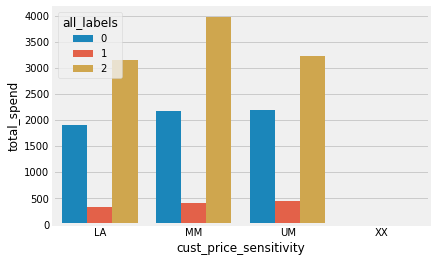

In [61]:
df_sens_avgspend = df_final.groupby(['cust_price_sensitivity','all_labels']).total_spend.mean().reset_index()
sns.barplot(x = 'cust_price_sensitivity', y='total_spend',hue = 'all_labels', data = df_sens_avgspend);

#Insight: MM customers spent the most but majority of customers are MM

In [62]:
df_final.head()

,cust_id,cust_price_sensitivity,cust_lifestage,total_spend,no_trans,L,M,S,LA,MM,UM,XX_x,Full Shop,Small Shop,Top Up,XX_y,Fresh,Grocery,Mixed,Nonfood,XX,all_labels
0,CUST0000000013,MM,YF,160.32,12,7.0,2.0,3.0,0.0,10.0,2.0,0.0,1.0,5.0,6.0,0.0,9.0,0.0,3.0,0.0,0.0,1
1,CUST0000000055,LA,YA,433.65,15,9.0,2.0,4.0,5.0,9.0,1.0,0.0,0.0,6.0,9.0,0.0,2.0,8.0,3.0,2.0,0.0,1
2,CUST0000000679,MM,OT,85.63,14,2.0,11.0,1.0,5.0,8.0,1.0,0.0,0.0,12.0,2.0,0.0,7.0,3.0,3.0,1.0,0.0,1
3,CUST0000001052,UM,PE,260.92,31,1.0,13.0,17.0,11.0,16.0,4.0,0.0,0.0,26.0,5.0,0.0,12.0,0.0,5.0,14.0,0.0,1
4,CUST0000001058,UM,OT,71.50,2,2.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1


In [63]:
df_cl0 = df_final[df_final['all_labels'] == 0]
df_cl1 = df_final[df_final['all_labels'] == 1]
df_cl2 = df_final[df_final['all_labels'] == 2]

In [355]:
#Deep diving into cluster 0 as they are the money makers with 26.9% of customer base and 59% of total sales
df_cl0.describe()

#Insight: cluster 0 = more L,M basket size, MM, Small Shop->Top Up, Fresh

,total_spend,no_trans,L,M,S,LA,MM,UM,XX_x,Full Shop,Small Shop,Top Up,XX_y,Fresh,Grocery,Mixed,Nonfood,XX,all_labels
count,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000,1343.0
mean,2107.751735,154.153388,58.168280,57.492926,38.492182,34.004468,78.038719,39.529412,2.580789,20.444527,79.965748,52.041698,1.701415,80.858526,26.080417,37.893522,7.619509,1.701415,0.0
std,1358.202215,48.929055,37.130855,32.707137,27.834722,31.849473,33.839764,32.954227,3.899347,23.971475,47.990672,30.705680,3.418551,38.811278,19.490708,19.126837,8.028292,3.418551,0.0
min,179.850000,67.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.0
25%,1091.215000,114.000000,27.000000,33.500000,17.000000,11.000000,54.000000,14.000000,0.000000,2.000000,43.000000,29.000000,0.000000,52.000000,12.000000,24.000000,2.000000,0.000000,0.0
50%,1799.610000,146.000000,55.000000,53.000000,34.000000,24.000000,73.000000,31.000000,1.000000,11.000000,75.000000,49.000000,1.000000,76.000000,21.000000,35.000000,5.000000,1.000000,0.0
75%,2840.115000,187.000000,85.000000,77.500000,54.000000,48.000000,99.000000,55.000000,3.000000,31.000000,109.000000,70.500000,2.000000,104.000000,35.000000,49.000000,10.000000,2.000000,0.0
max,14684.060000,321.000000,230.000000,190.000000,165.000000,187.000000,244.000000,222.000000,41.000000,162.000000,276.000000,223.000000,42.000000,294.000000,137.000000,119.000000,69.000000,42.000000,0.0


In [356]:
df_cl0.columns

Index(['cust_id', 'cust_price_sensitivity', 'cust_lifestage', 'total_spend',
       'no_trans', 'L', 'M', 'S', 'LA', 'MM', 'UM', 'XX_x', 'Full Shop',
       'Small Shop', 'Top Up', 'XX_y', 'Fresh', 'Grocery', 'Mixed', 'Nonfood',
       'XX', 'all_labels'],
      dtype='object')

In [359]:
df_cl0.groupby('cust_lifestage')['L','total_spend'].sum().reset_index().sort_values('total_spend',ascending=False)

,cust_lifestage,L,total_spend
2,OT,23150.0,859274.37
5,YF,15262.0,597304.51
4,YA,9799.0,361867.54
0,OA,10556.0,356670.71
3,PE,6616.0,169939.23
1,OF,3443.0,137963.77


In [360]:
df_cl0.groupby('cust_lifestage')['M','total_spend'].sum().reset_index().sort_values('total_spend',ascending=False)

,cust_lifestage,M,total_spend
2,OT,21958.0,859274.37
5,YF,11931.0,597304.51
4,YA,13205.0,361867.54
0,OA,11055.0,356670.71
3,PE,7102.0,169939.23
1,OF,3036.0,137963.77


In [361]:
df_cl0.groupby('cust_lifestage')['MM','total_spend'].sum().reset_index().sort_values('total_spend',ascending=False)

,cust_lifestage,MM,total_spend
2,OT,30753.0,859274.37
5,YF,19085.0,597304.51
4,YA,16882.0,361867.54
0,OA,13297.0,356670.71
3,PE,8029.0,169939.23
1,OF,4695.0,137963.77


In [363]:
df_cl0.groupby('cust_lifestage')['Small Shop','total_spend'].sum().reset_index().sort_values('total_spend',ascending=False)

,cust_lifestage,Small Shop,total_spend
2,OT,30685.0,859274.37
5,YF,16938.0,597304.51
4,YA,19260.0,361867.54
0,OA,14455.0,356670.71
3,PE,8889.0,169939.23
1,OF,4325.0,137963.77


In [364]:
df_cl0.groupby('cust_lifestage')['Fresh','total_spend'].sum().reset_index().sort_values('total_spend',ascending=False)

,cust_lifestage,Fresh,total_spend
2,OT,31327.0,859274.37
5,YF,17644.0,597304.51
4,YA,17030.0,361867.54
0,OA,15468.0,356670.71
3,PE,9903.0,169939.23
1,OF,4087.0,137963.77


In [65]:
df_cl0.isnull().sum()*100/df_cl1.shape[0]

#4.64% of customers in cluster 0 do not have a lifestage 

cust_id                   0.000000
cust_price_sensitivity    0.000000
cust_lifestage            4.642962
total_spend               0.000000
no_trans                  0.000000
L                         0.000000
M                         0.000000
S                         0.000000
LA                        0.000000
MM                        0.000000
UM                        0.000000
XX_x                      0.000000
Full Shop                 0.000000
Small Shop                0.000000
Top Up                    0.000000
XX_y                      0.000000
Fresh                     0.000000
Grocery                   0.000000
Mixed                     0.000000
Nonfood                   0.000000
XX                        0.000000
all_labels                0.000000
dtype: float64

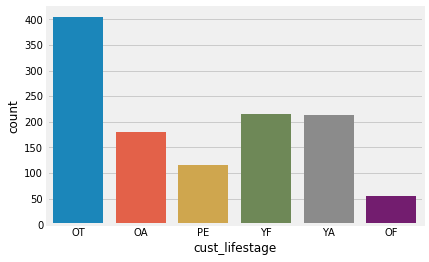

In [66]:
sns.countplot(x = 'cust_lifestage', data = df_cl0);

In [67]:
df_cl0.head()

,cust_id,cust_price_sensitivity,cust_lifestage,total_spend,no_trans,L,M,S,LA,MM,UM,XX_x,Full Shop,Small Shop,Top Up,XX_y,Fresh,Grocery,Mixed,Nonfood,XX,all_labels
7,CUST0000001392,LA,OT,3130.69,156,108.0,29.0,19.0,28.0,115.0,12.0,1.0,67.0,31.0,57.0,1.0,92.0,1.0,60.0,2.0,1.0,0
9,CUST0000001437,MM,OA,830.74,120,21.0,71.0,28.0,25.0,73.0,22.0,0.0,1.0,73.0,46.0,0.0,60.0,6.0,37.0,17.0,0.0,0
12,CUST0000002218,LA,PE,579.02,139,40.0,79.0,20.0,54.0,58.0,25.0,2.0,0.0,83.0,54.0,2.0,104.0,8.0,25.0,0.0,2.0,0
16,CUST0000003190,UM,OA,1504.11,116,82.0,31.0,3.0,4.0,52.0,60.0,0.0,19.0,5.0,92.0,0.0,23.0,18.0,74.0,1.0,0.0,0
17,CUST0000003347,MM,OA,5237.09,148,99.0,29.0,20.0,14.0,76.0,54.0,4.0,51.0,41.0,53.0,3.0,76.0,25.0,42.0,2.0,3.0,0


In [425]:
#df_cl0.groupby('cust_lifestage')['cust_id'].count().reset_index()
df_cl0['cust_lifestage'].value_counts(normalize=False).to_frame().reset_index()


,index,cust_lifestage
0,OT,404
1,YF,216
2,YA,214
3,OA,180
4,PE,115
5,OF,56


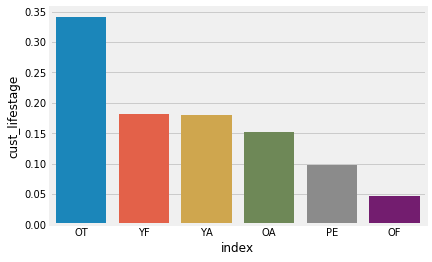

In [69]:
sns.barplot(x = 'index', y='cust_lifestage',data = df_cl0['cust_lifestage'].value_counts(normalize=True).to_frame().reset_index());

#Insight: majority of people in cluster 0 are OTher

In [70]:
df_cl0.groupby('cust_lifestage')['total_spend'].sum().reset_index().sort_values('total_spend',ascending=False)

,cust_lifestage,total_spend
2,OT,859274.37
5,YF,597304.51
4,YA,361867.54
0,OA,356670.71
3,PE,169939.23
1,OF,137963.77


In [71]:
df_cl0.groupby('cust_lifestage')['total_spend'].mean().reset_index().sort_values('total_spend',ascending=False)

,cust_lifestage,total_spend
5,YF,2765.298657
1,OF,2463.638750
2,OT,2126.916757
0,OA,1981.503944
4,YA,1690.969813
3,PE,1477.732435


<Figure size 432x288 with 0 Axes>

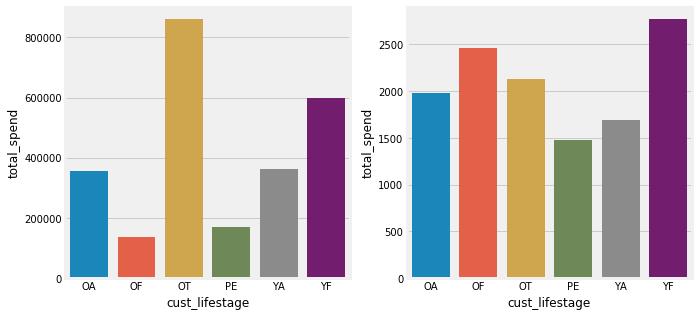

In [72]:
plt.tight_layout()
fig, axs = plt.subplots(1,2,figsize=(10, 5))

#Total spend by customer life stage
sns.barplot(x = 'cust_lifestage', y='total_spend',data = df_cl0.groupby('cust_lifestage')['total_spend'].sum().reset_index(),ax=axs[0]);

#Average spend by customer life stage
sns.barplot(x = 'cust_lifestage', y='total_spend',data = df_cl0.groupby('cust_lifestage')['total_spend'].mean().reset_index(),ax=axs[1]);

#Insight: Majority of total sales are coming from Other(34% of customers are OTHER); who the fuck is other 
# - Young families are 2nd followed by YA OA PE OF

#Insight: YF have the highest average spend followed by OF, OT, OA, YA, PE
# young families can grow to become older families who are the 2nd highest average

<Figure size 432x288 with 0 Axes>

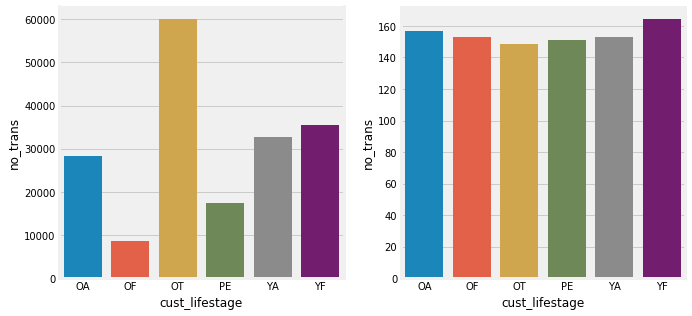

In [73]:
plt.tight_layout()
fig, axs = plt.subplots(1,2,figsize=(10, 5))

#Total spend by customer life stage
sns.barplot(x = 'cust_lifestage', y='no_trans',data = df_cl0.groupby('cust_lifestage')['no_trans'].sum().reset_index(),ax=axs[0]);

#Average spend by customer life stage
sns.barplot(x = 'cust_lifestage', y='no_trans',data = df_cl0.groupby('cust_lifestage')['no_trans'].mean().reset_index(),ax=axs[1]);

#Insight: similar result as total spend: total #of transactions are the same
# - average #of transactions are relatively equal to one another 

<Figure size 432x288 with 0 Axes>

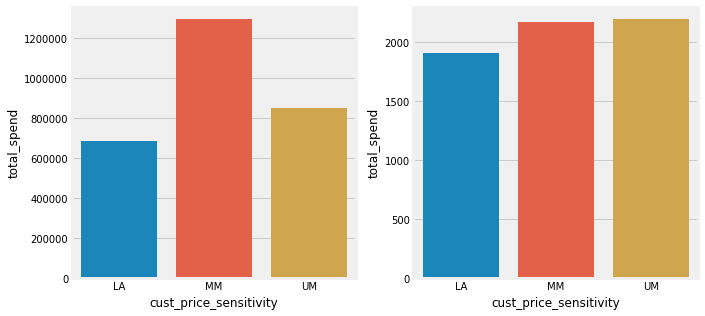

In [74]:
plt.tight_layout()
fig, axs = plt.subplots(1,2,figsize=(10, 5))

#Total spend by customer life stage
sns.barplot(x = 'cust_price_sensitivity', y='total_spend',data = df_cl0.groupby('cust_price_sensitivity')['total_spend'].sum().reset_index(),ax=axs[0]);

#Average spend by customer life stage
sns.barplot(x = 'cust_price_sensitivity', y='total_spend',data = df_cl0.groupby('cust_price_sensitivity')['total_spend'].mean().reset_index(),ax=axs[1]);

#Insight: price sensitivity doesn't really matter with total spend or average

<Figure size 432x288 with 0 Axes>

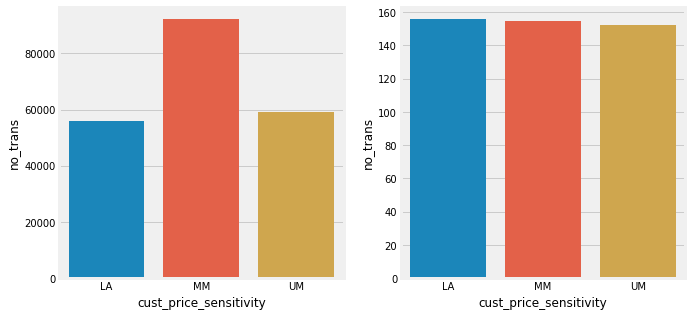

In [75]:
plt.tight_layout()
fig, axs = plt.subplots(1,2,figsize=(10, 5))

#Total spend by customer life stage
sns.barplot(x = 'cust_price_sensitivity', y='no_trans',data = df_cl0.groupby('cust_price_sensitivity')['no_trans'].sum().reset_index(),ax=axs[0]);

#Average spend by customer life stage
sns.barplot(x = 'cust_price_sensitivity', y='no_trans',data = df_cl0.groupby('cust_price_sensitivity')['no_trans'].mean().reset_index(),ax=axs[1]);

#Insight: price sensitivity doesn't really matter with #of transactions or average

In [76]:
df_store = pd.read_csv('df_store.csv')

In [77]:
df_store.head()

,cust_id,basket_id,store_id,spend,st_format,st_region
0,CUST0000000013,994105500169368,STORE02747,0.95,MS,N03
1,CUST0000000013,994105500169368,STORE02747,0.97,MS,N03
2,CUST0000000013,994105500169368,STORE02747,0.98,MS,N03
3,CUST0000000013,994105500169368,STORE02747,1.04,MS,N03
4,CUST0000000013,994105500169368,STORE02747,1.34,MS,N03


In [78]:
df_cl0.head()

,cust_id,cust_price_sensitivity,cust_lifestage,total_spend,no_trans,L,M,S,LA,MM,UM,XX_x,Full Shop,Small Shop,Top Up,XX_y,Fresh,Grocery,Mixed,Nonfood,XX,all_labels
7,CUST0000001392,LA,OT,3130.69,156,108.0,29.0,19.0,28.0,115.0,12.0,1.0,67.0,31.0,57.0,1.0,92.0,1.0,60.0,2.0,1.0,0
9,CUST0000001437,MM,OA,830.74,120,21.0,71.0,28.0,25.0,73.0,22.0,0.0,1.0,73.0,46.0,0.0,60.0,6.0,37.0,17.0,0.0,0
12,CUST0000002218,LA,PE,579.02,139,40.0,79.0,20.0,54.0,58.0,25.0,2.0,0.0,83.0,54.0,2.0,104.0,8.0,25.0,0.0,2.0,0
16,CUST0000003190,UM,OA,1504.11,116,82.0,31.0,3.0,4.0,52.0,60.0,0.0,19.0,5.0,92.0,0.0,23.0,18.0,74.0,1.0,0.0,0
17,CUST0000003347,MM,OA,5237.09,148,99.0,29.0,20.0,14.0,76.0,54.0,4.0,51.0,41.0,53.0,3.0,76.0,25.0,42.0,2.0,3.0,0


In [79]:
#Filter store information by cluster 0
df_store_cl0 = df_store[df_store['cust_id'].isin(df_cl0['cust_id'])]

In [80]:
df_store_cl0.head()

,cust_id,basket_id,store_id,spend,st_format,st_region
675,CUST0000001392,994100100153442,STORE01616,0.45,LS,N02
676,CUST0000001392,994100100153442,STORE01616,0.67,LS,N02
677,CUST0000001392,994100100153442,STORE01616,0.89,LS,N02
678,CUST0000001392,994100100153442,STORE01616,0.96,LS,N02
679,CUST0000001392,994100100153442,STORE01616,0.97,LS,N02


In [441]:
df_store_cl0_LS = df_store_cl0[df_store_cl0['st_format']=='LS']

In [442]:
df_store_cl0_LS.shape

(967793, 6)

In [398]:
df_store_cl0.groupby('st_format')['spend'].sum().to_frame().reset_index()

,st_format,spend
0,LS,1.894267e+06
1,MS,5.385990e+05
2,SS,1.362640e+05
3,XLS,2.239889e+05


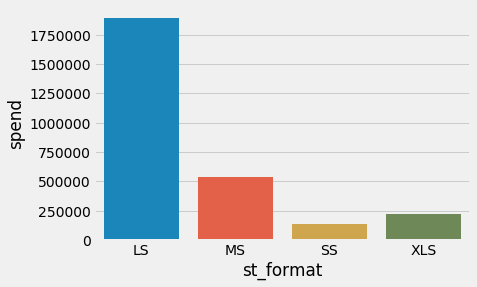

In [444]:
sns.barplot(x = 'st_format', y='spend',data = df_store_cl0.groupby('st_format')['spend'].sum().to_frame().reset_index());

In [433]:
df_store_cl0_LS.groupby('st_region')['spend'].sum().to_frame().reset_index()

,st_region,spend
0,E01,153841.92
1,E02,100239.90
2,E03,152521.06
3,N01,183391.50
4,N02,196560.19
5,N03,146793.68
6,S01,116373.55
7,S02,196312.93
8,S03,164109.27
9,W01,129154.00


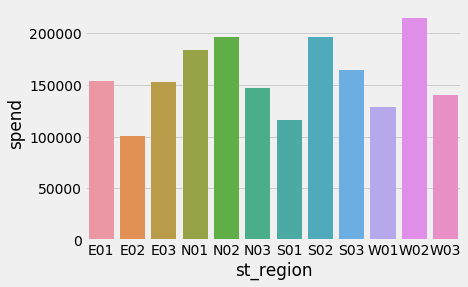

In [432]:
sns.barplot(x = 'st_region', y='spend',data = df_store_cl0_LS.groupby('st_region')['spend'].sum().to_frame().reset_index());

In [116]:
df_time = pd.read_csv('df_time.csv')

In [117]:
df_time.head()

,cust_id,basket_id,spend,shop_date,shop_hour
0,CUST0000000013,994105500169368,0.95,20070423,21
1,CUST0000000013,994105500169368,0.97,20070423,21
2,CUST0000000013,994105500169368,0.98,20070423,21
3,CUST0000000013,994105500169368,1.04,20070423,21
4,CUST0000000013,994105500169368,1.34,20070423,21


In [118]:
#Convert shop_date to datetime type variable
df_time['shop_date'] = pd.to_datetime(df_time['shop_date'], format = '%Y%m%d')

In [119]:
df_time.dtypes

cust_id              object
basket_id             int64
spend               float64
shop_date    datetime64[ns]
shop_hour             int64
dtype: object

In [120]:
#Let's filter out the dates for cluster 0
df_time_cl0 = df_time[df_time['cust_id'].isin(df_cl0['cust_id'])]

In [412]:
df_time_cl0.head()

,cust_id,basket_id,spend,shop_date,shop_hour,shop_day,shop_month,shop_year
675,CUST0000001392,994100100153442,0.45,2006-04-10,14,Monday,April,2006
676,CUST0000001392,994100100153442,0.67,2006-04-10,14,Monday,April,2006
677,CUST0000001392,994100100153442,0.89,2006-04-10,14,Monday,April,2006
678,CUST0000001392,994100100153442,0.96,2006-04-10,14,Monday,April,2006
679,CUST0000001392,994100100153442,0.97,2006-04-10,14,Monday,April,2006


In [128]:
df_time_cl0.groupby('shop_hour')['spend'].count().to_frame().reset_index()

,shop_hour,spend
0,8,60946
1,9,53210
2,10,74884
3,11,101687
4,12,122583
5,13,137043
6,14,141488
7,15,130946
8,16,123773
9,17,112115


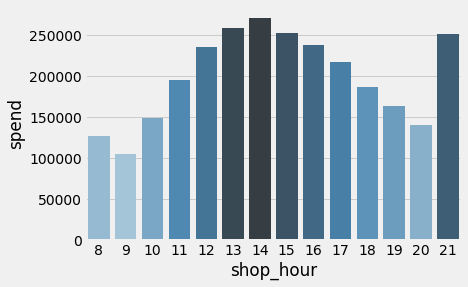

In [446]:
#Let's make this graph have darker bars where spend is the highest
data = df_time_cl0.groupby('shop_hour')['spend'].sum()
pal = sns.color_palette("Blues_d", len(data))
rank = data.argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638

sns.barplot(x = data.index, y=data, palette = np.array(pal[::-1])[rank]);

In [150]:
#Convert our dates to weekdays
df_time_cl0['shop_day'] = df_time_cl0['shop_date'].dt.day_name()

/Users/gthorani/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


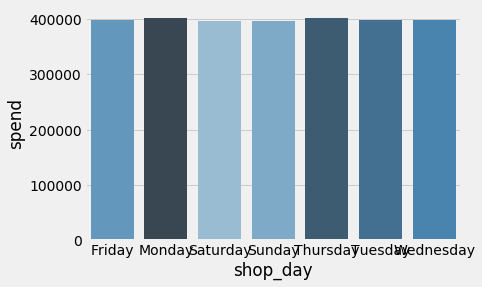

In [414]:
#Let's do the same but with weekday now
data = df_time_cl0.groupby('shop_day')['spend'].sum()
pal = sns.color_palette("Blues_d", len(data))
rank = data.argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638

sns.barplot(x = data.index, y=data, palette = np.array(pal[::-1])[rank]);

In [166]:
#Convert our dates to months
df_time_cl0['shop_month'] = df_time_cl0['shop_date'].dt.month_name()

/Users/gthorani/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [212]:
df_time_cl0_month = df_time_cl0.groupby('shop_month')['spend'].sum().to_frame().reset_index().sort_values(by='shop_month')

In [213]:
df_time_cl0_month = df_time_cl0_month.reindex([4,3,7,0,8,6,5,1,11,10,9,2])

In [187]:
df_time_cl0_month = df_time_cl0_month.set_index('shop_month')

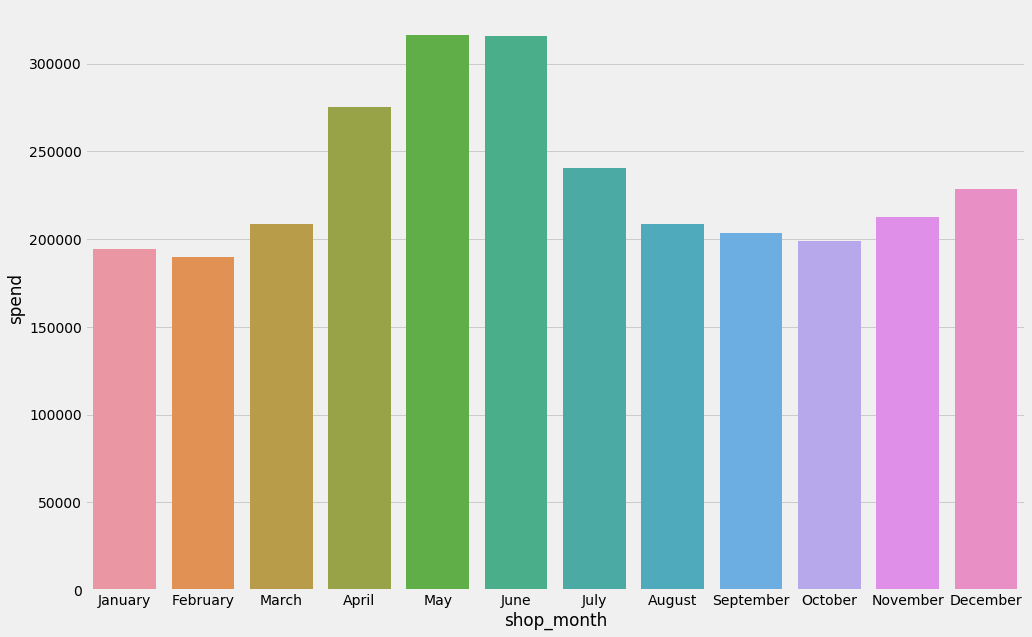

In [314]:
#Let's do the same but with weekday now
plt.figure(figsize=(15, 10))
# data = df_time_cl0_month.values
# pal = sns.color_palette("Blues_d", len(data))
# rank = data.argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638

# sns.barplot(x = data.index, y=data, palette = np.array(pal[::-1])[rank]);
sns.barplot(x = 'shop_month', y='spend',data = df_time_cl0_month);

In [220]:
#Convert our dates to year
df_time_cl0['shop_year'] = df_time_cl0['shop_date'].dt.year

/Users/gthorani/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [224]:
df_time_cl0.head()

,cust_id,basket_id,spend,shop_date,shop_hour,shop_day,shop_month,shop_year
675,CUST0000001392,994100100153442,0.45,2006-04-10,14,Monday,April,2006
676,CUST0000001392,994100100153442,0.67,2006-04-10,14,Monday,April,2006
677,CUST0000001392,994100100153442,0.89,2006-04-10,14,Monday,April,2006
678,CUST0000001392,994100100153442,0.96,2006-04-10,14,Monday,April,2006
679,CUST0000001392,994100100153442,0.97,2006-04-10,14,Monday,April,2006


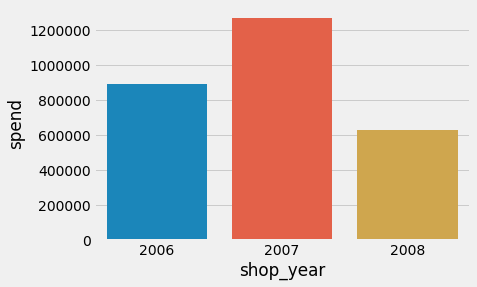

In [230]:
sns.barplot(x = 'shop_year', y='spend',data = df_time_cl0.groupby('shop_year')['spend'].sum().to_frame().reset_index());

In [386]:
df_time_cl0_2006 = df_time_cl0[df_time_cl0['shop_year'] == 2006]
df_time_cl0_2007 = df_time_cl0[df_time_cl0['shop_year'] == 2007]
df_time_cl0_2008 = df_time_cl0[df_time_cl0['shop_year'] == 2008]

In [336]:
df_time_cl0_2006_month = df_time_cl0_2006.groupby('shop_month')['spend'].sum().to_frame().reset_index().sort_values(by='shop_month')

df_time_cl0_2007_month = df_time_cl0_2007.groupby('shop_month')['spend'].sum().to_frame().reset_index().sort_values(by='shop_month')

df_time_cl0_2008_month = df_time_cl0_2008.groupby('shop_month')['spend'].sum().to_frame().reset_index().sort_values(by='shop_month')

#There isn't jan,feb,mar in 2006

In [338]:
df_addon_2006 = pd.DataFrame([['January',0],['February',0],['March',0]], columns=list(['shop_month','spend']))
df_addon_2008 = pd.DataFrame([['August',0],['September',0],['October',0],['November',0],['December',0]], columns=list(['shop_month','spend']))

In [339]:
df_time_cl0_2006_month = df_time_cl0_2006_month.append(df_addon_2006, ignore_index=True)
df_time_cl0_2008_month = df_time_cl0_2008_month.append(df_addon_2008, ignore_index=True)

In [340]:
df_time_cl0_2006_month

,shop_month,spend
0,April,68086.97
1,August,98705.23
2,December,116522.37
3,July,106614.20
4,June,103077.91
5,May,102020.62
6,November,102610.75
7,October,97853.02
8,September,99281.34
9,January,0.00


In [341]:
df_time_cl0_2007_month

,shop_month,spend
0,April,104102.34
1,August,110168.82
2,December,111994.06
3,February,95667.03
4,January,99020.70
5,July,111373.64
6,June,109361.01
7,March,105354.57
8,May,107924.15
9,November,110150.46


In [447]:
df_time_cl0_2008_month

,shop_month,spend
2,January,95142.51
1,February,94203.66
5,March,103200.55
0,April,103020.34
6,May,106581.96
4,June,103513.38
3,July,22496.14
7,August,0.00
8,September,0.00
9,October,0.00


In [342]:
df_time_cl0_2006_month = df_time_cl0_2006_month.reindex([9,10,11,0,5,4,3,1,8,7,6,2])
df_time_cl0_2007_month = df_time_cl0_2007_month.reindex([4,3,7,0,8,6,5,1,11,10,9,2])
df_time_cl0_2008_month = df_time_cl0_2008_month.reindex([2,1,5,0,6,4,3,7,8,9,10,11])

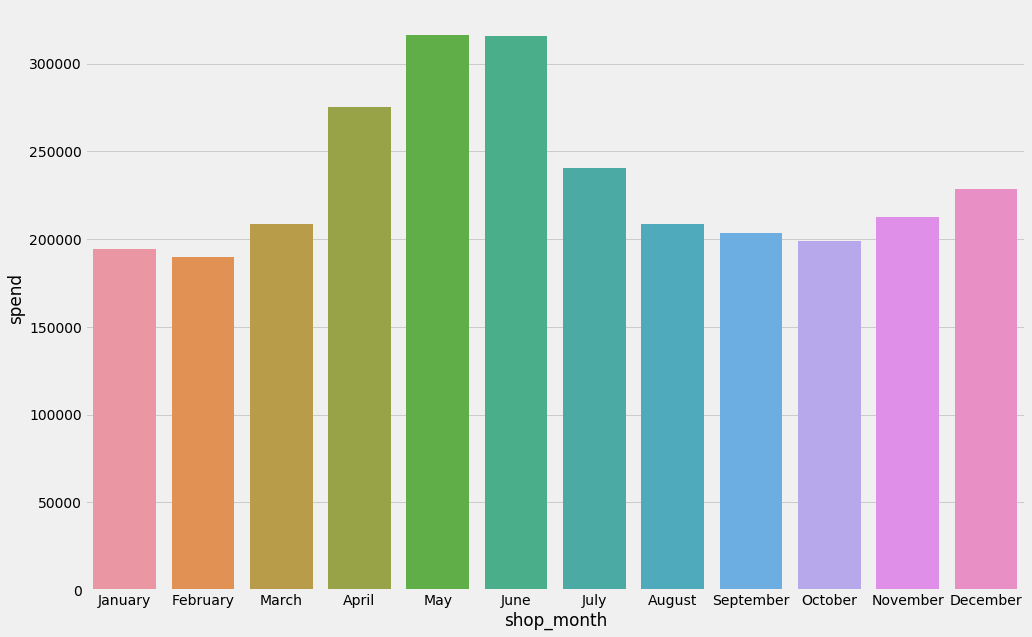

In [343]:
#Let's do the same but with weekday now
plt.figure(figsize=(15, 10))
# data = df_time_cl0_month.values
# pal = sns.color_palette("Blues_d", len(data))
# rank = data.argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638

# sns.barplot(x = data.index, y=data, palette = np.array(pal[::-1])[rank]);
sns.barplot(x = 'shop_month', y='spend',data = df_time_cl0_month);

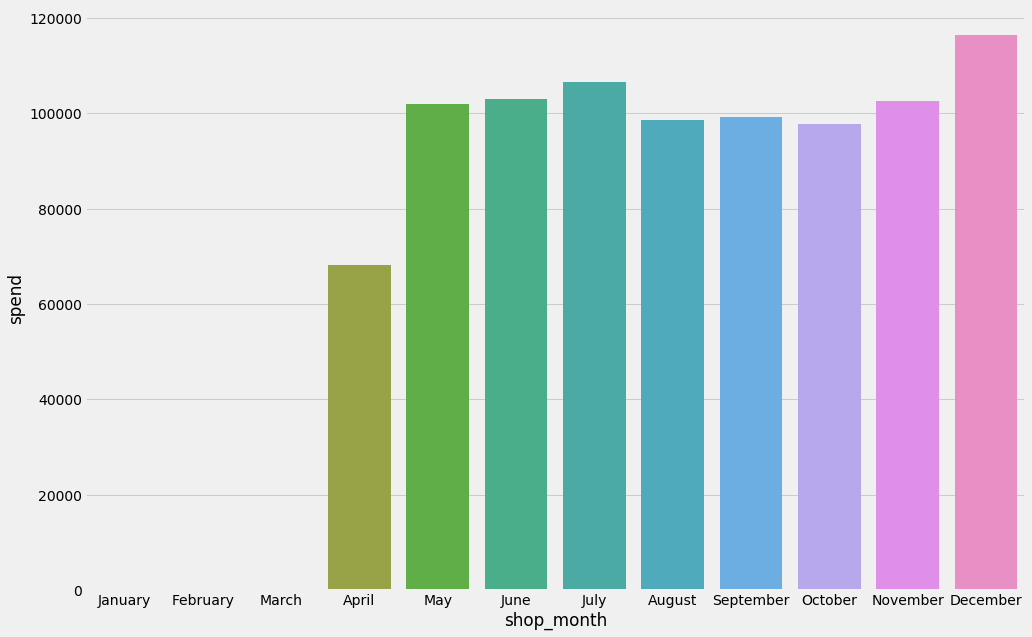

In [344]:
#Let's do the same but with weekday now
plt.figure(figsize=(15, 10))
# data = df_time_cl0_month.values
# pal = sns.color_palette("Blues_d", len(data))
# rank = data.argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638

# sns.barplot(x = data.index, y=data, palette = np.array(pal[::-1])[rank]);
sns.barplot(x = 'shop_month', y='spend',data = df_time_cl0_2006_month);

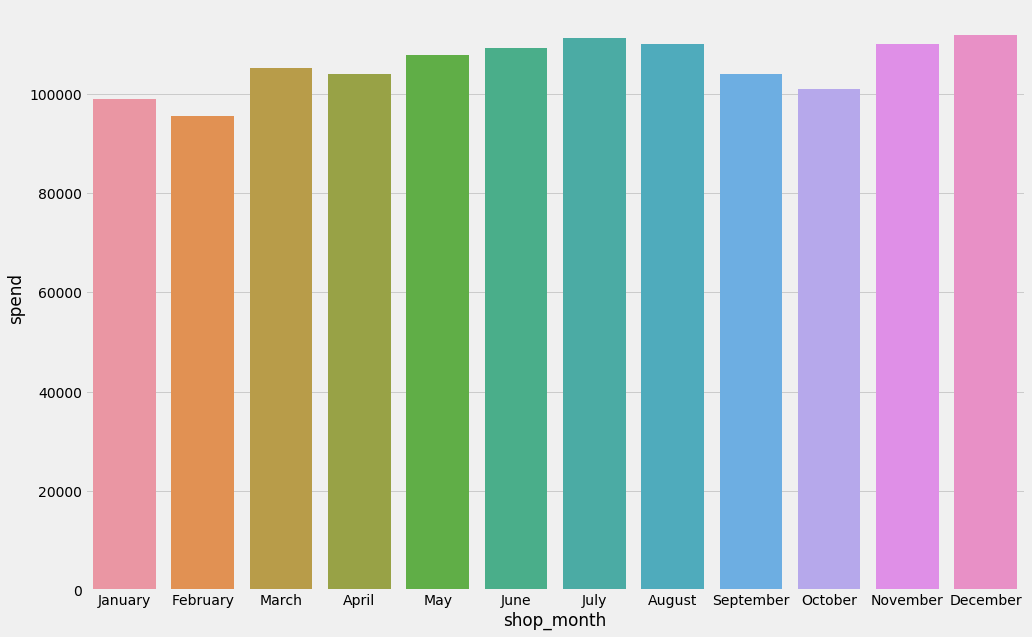

In [345]:
#Let's do the same but with weekday now
plt.figure(figsize=(15, 10))
# data = df_time_cl0_month.values
# pal = sns.color_palette("Blues_d", len(data))
# rank = data.argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638

# sns.barplot(x = data.index, y=data, palette = np.array(pal[::-1])[rank]);
sns.barplot(x = 'shop_month', y='spend',data = df_time_cl0_2007_month);

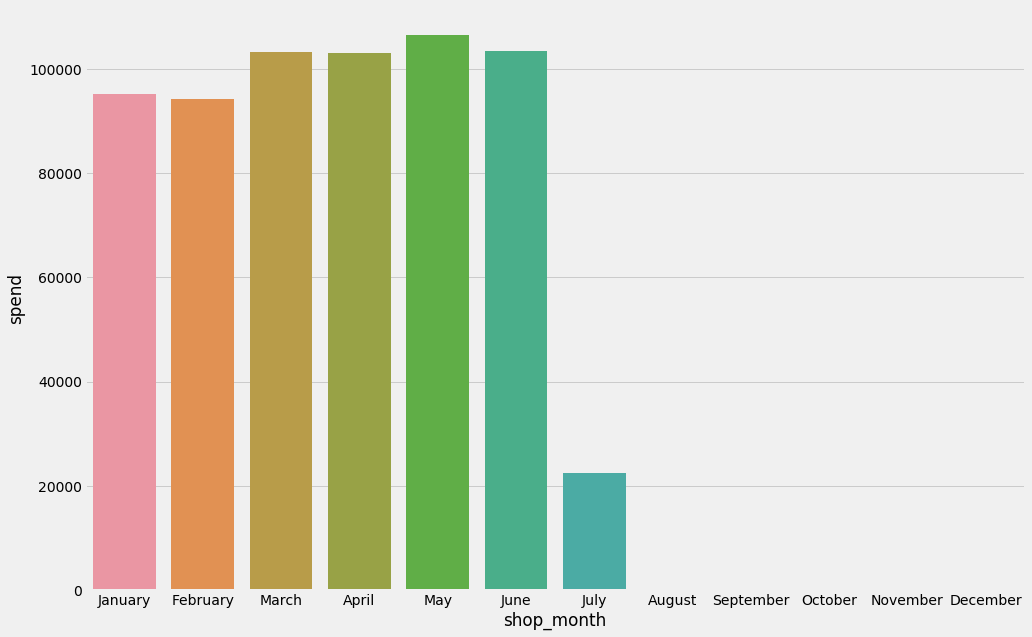

In [350]:
#Let's do the same but with weekday now
plt.figure(figsize=(15, 10))
# data = df_time_cl0_month.values
# pal = sns.color_palette("Blues_d", len(data))
# rank = data.argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638

# sns.barplot(x = data.index, y=data, palette = np.array(pal[::-1])[rank]);
sns.barplot(x = 'shop_month', y='spend',data = df_time_cl0_2008_month);

<Figure size 432x288 with 0 Axes>

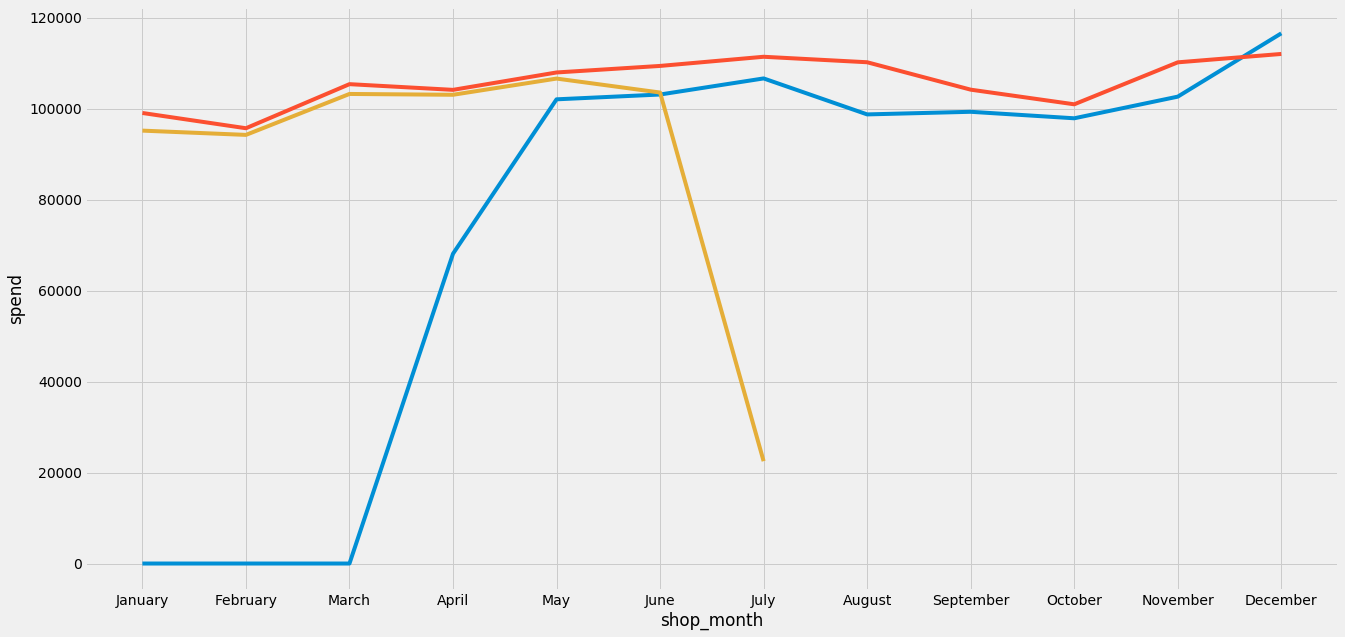

In [421]:
plt.tight_layout()
fig, axs = plt.subplots(1,1,figsize=(20, 10))

#All time
#sns.lineplot(x = 'shop_month', y='spend',data = df_time_cl0_month,sort=False);

#2006 blue
sns.lineplot(x = 'shop_month', y='spend',data = df_time_cl0_2006_month,sort=False);

#2007 red
sns.lineplot(x = 'shop_month', y='spend',data = df_time_cl0_2007_month,sort=False);

#2008 yellow
sns.lineplot(x = 'shop_month', y='spend',data = df_time_cl0_2008_month[0:7],sort=False);

#Insight: deep dive into the products that are being sold every month